# Imports

In [412]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import regularizers

# Load Data

In [339]:
data = pd.read_csv('data/DC_Properties.csv')

C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Exploration

In [340]:
data.shape # we have 49 columns and 158957 rows

(158957, 49)

In [341]:
missing_values = data.isnull().sum()

print("Row Count: " + str(data.shape[0]))
print()
print(missing_values)

Row Count: 158957

Unnamed: 0                 0
BATHRM                     0
HF_BATHRM                  0
HEAT                       0
AC                         0
NUM_UNITS              52261
ROOMS                      0
BEDRM                      0
AYB                      271
YR_RMDL                78029
EYB                        0
STORIES                52305
SALEDATE               26770
PRICE                  60741
QUALIFIED                  0
SALE_NUM                   0
GBA                    52261
BLDG_NUM                   0
STYLE                  52261
STRUCT                 52261
GRADE                  52261
CNDTN                  52261
EXTWALL                52261
ROOF                   52261
INTWALL                52261
KITCHENS               52262
FIREPLACES                 0
USECODE                    0
LANDAREA                   0
GIS_LAST_MOD_DTTM          0
SOURCE                     0
CMPLX_NUM             106696
LIVING_GBA            106696
FULLADDRESS            5

In [342]:
data[data["STYLE"].notnull()].shape # 52.261 rows don't have a value for the "STYLE" column

(106696, 49)

In [343]:
data[data["STRUCT"].notnull() | data["STYLE"].notnull() | data["GRADE"].notnull() | data["CNDTN"].notnull() | data["EXTWALL"].notnull() | data["ROOF"].notnull() | data["INTWALL"].notnull()].shape # the same rows don't have a value for: "STRUCT", "GRADE", "CNDTN", "EXTWALL", "ROOF", "INTWALL"

(106696, 49)

In [344]:
# command copied form data cleaning
data_dropped_rows = data[data["STRUCT"].notnull() | data["STYLE"].notnull() | data["GRADE"].notnull() | data["CNDTN"].notnull() | data["EXTWALL"].notnull() | data["ROOF"].notnull() | data["INTWALL"].notnull()]

In [345]:
missing_values = data_dropped_rows.isnull().sum()

print("Row Count: " + str(data_dropped_rows.shape[0]))
print()
print(missing_values)

Row Count: 106696

Unnamed: 0                 0
BATHRM                     0
HF_BATHRM                  0
HEAT                       0
AC                         0
NUM_UNITS                  0
ROOMS                      0
BEDRM                      0
AYB                      241
YR_RMDL                57417
EYB                        0
STORIES                   44
SALEDATE               22513
PRICE                  48796
QUALIFIED                  0
SALE_NUM                   0
GBA                        0
BLDG_NUM                   0
STYLE                      0
STRUCT                     0
GRADE                      0
CNDTN                      0
EXTWALL                    0
ROOF                       0
INTWALL                    0
KITCHENS                   1
FIREPLACES                 0
USECODE                    0
LANDAREA                   0
GIS_LAST_MOD_DTTM          0
SOURCE                     0
CMPLX_NUM             106696
LIVING_GBA            106696
FULLADDRESS             

1) no row has a value for the cmplx_num and the living_gba => useless
2) there are many missing values for the sale_date and the yr_rmdl => maybe they aren't missing, it could be the case, that these houses were never remodeled and/ or sold before, in the following we will probably handle them this way.

There is a column called "Unnamed: 0", lets see what's in there.

In [346]:
data["Unnamed: 0"]

0              0
1              1
2              2
3              3
4              4
5              5
6              6
7              7
8              8
9              9
10            10
11            11
12            12
13            13
14            14
15            15
16            16
17            17
18            18
19            19
20            20
21            21
22            22
23            23
24            24
25            25
26            26
27            27
28            28
29            29
           ...  
158927    158927
158928    158928
158929    158929
158930    158930
158931    158931
158932    158932
158933    158933
158934    158934
158935    158935
158936    158936
158937    158937
158938    158938
158939    158939
158940    158940
158941    158941
158942    158942
158943    158943
158944    158944
158945    158945
158946    158946
158947    158947
158948    158948
158949    158949
158950    158950
158951    158951
158952    158952
158953    158953
158954    1589

It's just the same as the index (probably the unique id column).

In [347]:
data["STATE"].unique() 

array(['DC', nan], dtype=object)

In [348]:
data["CITY"].unique()

array(['WASHINGTON', nan], dtype=object)

Since our dataset is only about Washington DC these columns habe no use.

In [349]:
data["ZIPCODE"].unique()

array([ 20009.,  20037.,  20036.,  20005.,  20052.,  20008.,  20001.,
        20024.,  20006.,  20003.,  20002.,  20007.,  20016.,  20015.,
        20011.,  20010.,  20012.,  20017.,  20018.,  20019.,  20020.,
        20032.,     nan,  20392.,  20004.])

The ZIPCODE on the otherside contains some value

In [350]:
data["FULLADDRESS"].unique()

array(['1748 SWANN STREET NW', '1746 SWANN STREET NW',
       '1744 SWANN STREET NW', ..., '131 JOLIET STREET SW',
       '135 JOLIET STREET SW', '139 JOLIET STREET SW'], dtype=object)

In [351]:
data["FULLADDRESS"].unique().shape

(105979,)

In [352]:
data.shape[0] - data["FULLADDRESS"].isnull().sum()

106040

The column "FULLADDRESS" has only unique text values, the computer can't process them. Either you split them up (street and house number or just leave them out because the streetnames aren't that useful either)

In [353]:
data["NATIONALGRID"].unique()

array(['18S UJ 23061 09289', '18S UJ 23067 09289', '18S UJ 23074 09289',
       ..., '18S UH 25815 98879', '18S UH 25807 98865',
       '18S UH 25804 98859'], dtype=object)

In [354]:
data["NATIONALGRID"].unique().shape

(105950,)

In [355]:
data.shape[0] - data["NATIONALGRID"].isnull().sum()

106051

The column "NATIONALGRID" has the same problem, as the one above.

In [356]:
data["GIS_LAST_MOD_DTTM"].unique()

array(['2018-07-22 18:01:43', '2018-07-22 18:01:38'], dtype=object)

This row says when the row of the dataset was last modified, it's useless for us.

In [357]:
data["SALEDATE"].unique()

array(['2003-11-25 00:00:00', '2000-08-17 00:00:00', '2016-06-21 00:00:00',
       ..., '1995-02-16 00:00:00', '1994-02-14 00:00:00',
       '1993-08-06 00:00:00'], dtype=object)

This row contains the date, the building was sold. The way it is saved is not good to compute, we will convert it later.

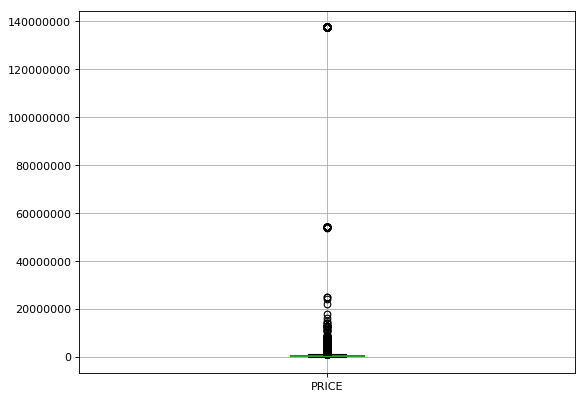

In [358]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ticklabel_format(style = 'plain')

data.boxplot(column=["PRICE"])
plt.show()

In [359]:
data.sort_values(by="PRICE")["PRICE"]

132821       1.0
148694       1.0
152131       1.0
81694        1.0
106683       1.0
18568       10.0
74419       10.0
81594       10.0
51658       10.0
48414      250.0
14041      250.0
55048      250.0
102782     250.0
43281      250.0
7396       250.0
42069      250.0
50971      250.0
49321      250.0
93541      250.0
94173      250.0
54909      250.0
49443      250.0
84165      250.0
49470      500.0
60597      500.0
5516       500.0
54229      500.0
3330       936.0
153470    1000.0
100485    1000.0
           ...  
158845       NaN
158847       NaN
158848       NaN
158849       NaN
158850       NaN
158852       NaN
158855       NaN
158856       NaN
158857       NaN
158859       NaN
158860       NaN
158863       NaN
158865       NaN
158866       NaN
158870       NaN
158872       NaN
158879       NaN
158883       NaN
158889       NaN
158913       NaN
158917       NaN
158922       NaN
158923       NaN
158925       NaN
158927       NaN
158937       NaN
158940       NaN
158941       N

The price of some buildings is suspicous, we have some verry verry high prices (140.000.000$) and some realy low prices (1$) 

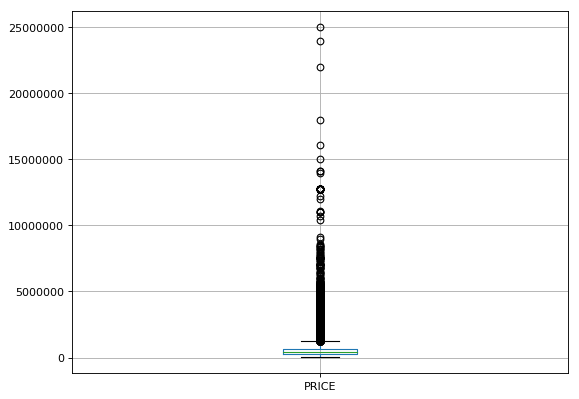

In [360]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ticklabel_format(style = 'plain')

data.loc[(data["PRICE"] <= 25000000) & (data["PRICE"] >= 60000)].boxplot(column=["PRICE"])
plt.show()

In [361]:
data["AC"].unique()

array(['Y', 'N', '0'], dtype=object)

A zero in there is strange value it stands for NULL, therefore we should replace it with NULL instead of 0.

In [362]:
data["BLDG_NUM"].unique()

array([1, 2, 3, 4, 5], dtype=int64)

We haven't found anything about this column in the documentation and since it has only two possible values, it seems kind of useless.

# Data Cleaning

## remove rows with missing values

In [363]:
# this command will throw away ~33% of the data (maybe we will keep the data and do two seperate tests, one where we will throw away the rows where the data is missing and one where we will throw away these columns)
# data = data[data["STRUCT"].notnull() | data["STYLE"].notnull() | data["GRADE"].notnull() | data["CNDTN"].notnull() | data["EXTWALL"].notnull() | data["ROOF"].notnull() | data["INTWALL"].notnull()]

# since our many concern is the price of the building, rows without the price have only a small to none value
data = data[data["PRICE"].notnull()]

# remove rows with strange prices
data = data.loc[(data["PRICE"] <= 25000000) & (data["PRICE"] >= 60000)]

# in these very few rows (~200) there are values missing
data = data[data["X"].notnull() & data["Y"].notnull() & data["QUADRANT"].notnull() & data["AYB"].notnull() & data["WARD"].notnull() & data["ASSESSMENT_NBHD"].notnull() & data["CENSUS_TRACT"].notnull() & data["LONGITUDE"].notnull() & data["LATITUDE"].notnull() & data["ZIPCODE"].notnull()]
data = data[data.ROOMS != 0]
data = data[data.AC != "0"]

## drop columns

In [364]:
# this column has only one value "2018-07-22 18:01:43" => useless
data = data.drop(["GIS_LAST_MOD_DTTM"], axis=1)
# since the unique id is equal to the row number we don't need it
data = data.drop(["Unnamed: 0"], axis=1)
# many many missing values
data = data.drop(["LIVING_GBA", "CMPLX_NUM"], axis=1)
# these columns have nothing to say
data = data.drop(["STATE", "CITY", "SOURCE", "BLDG_NUM"], axis=1)
# these columns contain only unique texts which can't be computed
data = data.drop(["NATIONALGRID", "FULLADDRESS"], axis=1)
# in our other notebook we proved that there is a realy high (< 0.999) correlation between x, y and longitude and latititude because in both show the longitude and latitdude of a building
data = data.drop(["X", "Y"], axis=1)
# this column has way to many unique values => makes the onehot encoded data really big. It correlates strongly with the other location information 
data = data.drop(["CENSUS_BLOCK"], axis=1)

## data insertion

In [365]:
# set the missing sale date to the year it was build
data["SALEDATE"] = np.where(data["SALEDATE"].isnull(), data["AYB"], data["SALEDATE"])

# add a column wich says wether a building was remodeled and insert missing values in to the YR_RMDL column
data["WAS_REMODELED"] = np.where(data["YR_RMDL"].isnull(), 0, 1)
data["YR_RMDL"] = np.where(data["YR_RMDL"].isnull(), -1, data["YR_RMDL"])

## data convertion

In [366]:
#convert saledate to datetime
data['SALEDATE'] = pd.to_datetime(data['SALEDATE'])
#Calculating the difference in years between Last Sale Date and Year Built
data['SalevYB']=data['SALEDATE'].dt.year - data['AYB']
#Calculating the difference in years between Last Sale Date and Year Improved
data['SalevYI']=data['SALEDATE'].dt.year - data['EYB']

data = data.drop(["SALEDATE", "EYB", "AYB"], axis=1)

## final results

In [367]:
missing_values = data.isnull().sum()
print("All Data:")
print("Row Count: " + str(data.shape[0]))
print("Col Count: " + str(data.shape[1]))
print()
print(missing_values)

data_col = data.drop(["NUM_UNITS", "STORIES", "GBA", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "ROOF", "INTWALL", "KITCHENS", "ASSESSMENT_SUBNBHD"], axis=1)
missing_values_col = data_col.isnull().sum()
print()
print("--------------------------------------------------")
print()
print("Data with dropped columns:")
print("Row Count: " + str(data_col.shape[0]))
print("Col Count: " + str(data_col.shape[1]))
print()
print(missing_values_col)

data_row = data[data["STRUCT"].notnull() & data["STYLE"].notnull() & data["GRADE"].notnull() & data["CNDTN"].notnull() & data["EXTWALL"].notnull() & data["ROOF"].notnull() & data["INTWALL"].notnull()  & data["STORIES"].notnull() & data["KITCHENS"].notnull() & data["ASSESSMENT_SUBNBHD"].notnull()]
missing_values_row = data_row.isnull().sum()
print()
print("--------------------------------------------------")
print()
print("Data with dropped rows:")
print("Row Count: " + str(data_row.shape[0]))
print("Col Count: " + str(data_row.shape[1]))
print()
print(missing_values_row)

All Data:
Row Count: 95797
Col Count: 36

BATHRM                    0
HF_BATHRM                 0
HEAT                      0
AC                        0
NUM_UNITS             38884
ROOMS                     0
BEDRM                     0
YR_RMDL                   0
STORIES               38916
PRICE                     0
QUALIFIED                 0
SALE_NUM                  0
GBA                   38884
STYLE                 38884
STRUCT                38884
GRADE                 38884
CNDTN                 38884
EXTWALL               38884
ROOF                  38884
INTWALL               38884
KITCHENS              38885
FIREPLACES                0
USECODE                   0
LANDAREA                  0
ZIPCODE                   0
LATITUDE                  0
LONGITUDE                 0
ASSESSMENT_NBHD           0
ASSESSMENT_SUBNBHD    19591
CENSUS_TRACT              0
WARD                      0
SQUARE                    0
QUADRANT                  0
WAS_REMODELED             0
SalevY

## save to csv

In [368]:
data_row.to_csv("data/data_cleaned_row.csv", index=False)
data_col.to_csv("data/data_cleaned_col.csv", index=False)

# Data Preparation

## subsample (for faster development -> remove (comment out) later)

## One Hot Encoding

In [369]:
data_row_one_hot = pd.get_dummies(data_row, prefix = ["HEAT", "AC", "QUALIFIED", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ZIPCODE", "ASSESSMENT_NBHD", "ASSESSMENT_SUBNBHD", "CENSUS_TRACT", "WARD", "QUADRANT", "WAS_REMODELED"], columns = ["HEAT", "AC", "QUALIFIED", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ZIPCODE", "ASSESSMENT_NBHD", "ASSESSMENT_SUBNBHD", "CENSUS_TRACT", "WARD", "QUADRANT", "WAS_REMODELED"])
data_col_one_hot = pd.get_dummies(data_col, prefix = ["HEAT", "AC", "QUALIFIED", "ZIPCODE", "ASSESSMENT_NBHD", "CENSUS_TRACT", "WARD", "QUADRANT", "WAS_REMODELED"], columns = ["HEAT", "AC", "QUALIFIED", "ZIPCODE", "ASSESSMENT_NBHD", "CENSUS_TRACT", "WARD", "QUADRANT", "WAS_REMODELED"])

for i in ["HEAT", "AC", "QUALIFIED", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ZIPCODE", "ASSESSMENT_NBHD", "ASSESSMENT_SUBNBHD", "CENSUS_TRACT", "WARD", "QUADRANT", "WAS_REMODELED"]:
    print(str(i) + ": " + str(data_row[i].unique().shape[0]))
    print()

HEAT: 14

AC: 2

QUALIFIED: 2

STYLE: 17

STRUCT: 8

GRADE: 12

CNDTN: 7

EXTWALL: 23

INTWALL: 12

ROOF: 15

ZIPCODE: 19

ASSESSMENT_NBHD: 33

ASSESSMENT_SUBNBHD: 121

CENSUS_TRACT: 152

WARD: 8

QUADRANT: 4

WAS_REMODELED: 2



## remove categorical data (needed for regression analysis)

In [370]:
data_row_no_cat = data_row.copy()
data_col_no_cat = data_col.copy()

In [371]:
data_row_no_cat = data_row_no_cat.drop(["HEAT", "AC", "QUALIFIED", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ZIPCODE", "ASSESSMENT_NBHD", "ASSESSMENT_SUBNBHD", "CENSUS_TRACT", "WARD", "QUADRANT", "WAS_REMODELED"], axis=1)
data_col_no_cat = data_col_no_cat.drop(["HEAT", "AC", "QUALIFIED", "ZIPCODE", "ASSESSMENT_NBHD", "CENSUS_TRACT", "WARD", "QUADRANT", "WAS_REMODELED"], axis=1)

## split the data (x and y)

In [372]:
x_row = data_row.drop(["PRICE"], axis=1)
x_row_one_hot = data_row_one_hot.drop(["PRICE"], axis=1)
x_row_no_cat = data_row_no_cat.drop(["PRICE"], axis=1)
y_row = data_row["PRICE"]

In [373]:
x_col = data_col.drop(["PRICE"], axis=1)
x_col_one_hot = data_col_one_hot.drop(["PRICE"], axis=1)
x_col_no_cat = data_col_no_cat.drop(["PRICE"], axis=1)
y_col = data_col["PRICE"]

## normalization

In [374]:
x_row_one_hot_norm = x_row_one_hot.copy()
x_row_one_hot_norm = x_row_one_hot_norm.astype(float)
x_row_one_hot_norm = x_row_one_hot_norm.apply(lambda x: (x - x.min()) / (x.max()-x.min()), axis=0)

In [375]:
x_col_one_hot_norm = x_col_one_hot.copy()
x_col_one_hot_norm = x_col_one_hot_norm.astype(float)
x_col_one_hot_norm = x_col_one_hot_norm.apply(lambda x: (x - x.min()) / (x.max()-x.min()), axis=0)

## split the data (train and test set)

In [376]:
split_size_row = round(data_row.shape[0] * 0.7)
split_size_col = round(data_col.shape[0] * 0.7)

In [377]:
x_row_train, x_row_test = np.split(x_row, [split_size_row], axis = 0)
x_row_one_hot_train, x_row_one_hot_test = np.split(x_row_one_hot, [split_size_row], axis = 0)
x_row_no_cat_train, x_row_no_cat_test = np.split(x_row_no_cat, [split_size_row], axis = 0)
x_row_one_hot_norm_train, x_row_one_hot_norm_test = np.split(x_row_one_hot_norm, [split_size_row], axis = 0)
y_row_train, y_row_test = np.split(y_row, [split_size_row], axis = 0)

In [378]:
x_col_train, x_col_test = np.split(x_col, [split_size_col], axis = 0)
x_col_one_hot_train, x_col_one_hot_test = np.split(x_col_one_hot, [split_size_col], axis = 0)
x_col_no_cat_train, x_col_no_cat_test = np.split(x_col_no_cat, [split_size_col], axis = 0)
x_col_one_hot_norm_train, x_col_one_hot_norm_test = np.split(x_col_one_hot_norm, [split_size_col], axis = 0)
y_col_train, y_col_test = np.split(y_col, [split_size_col], axis = 0)

# Use Linear Regression

## train the model

In [379]:
print("Start trianing")
linreg_row = LinearRegression(n_jobs = -1, normalize = True)
linreg_row.fit(x_row_no_cat_train, y_row_train)
print("End training")

Start trianing
End training


In [380]:
print("Start trianing")
linreg_col = LinearRegression(n_jobs = -1, normalize = True)
linreg_col.fit(x_col_no_cat_train, y_col_train)
print("End training")

Start trianing
End training


## predict the test data

In [381]:
y_row_lin_pred = linreg_row.predict(x_row_no_cat_test)

In [382]:
y_col_lin_pred = linreg_col.predict(x_col_no_cat_test)

## analyze results

In [383]:
row_lin_score = linreg_row.score(x_row_no_cat_test, y_row_test)
row_lin_msqe = mean_squared_error(y_row_test, y_row_lin_pred)
print("R2 score for the row dataset: " + str(row_lin_score))
print("Mean squared error for the row dataset: " + str(row_lin_msqe))

R2 score for the row dataset: -1.70080289765
Mean squared error for the row dataset: 122654486435.0


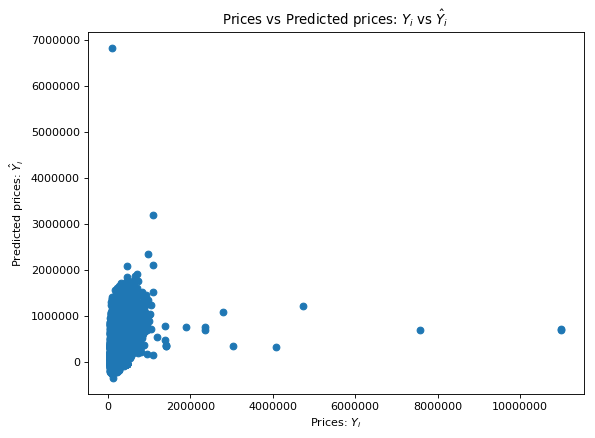

In [384]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ticklabel_format(style = 'plain')

plt.scatter(y_row_test, y_row_lin_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

In [385]:
col_lin_score = linreg_col.score(x_col_no_cat_test, y_col_test)
col_lin_msqe = mean_squared_error(y_col_test, y_col_lin_pred)
print("R2 score for the column dataset: " + str(col_lin_score))
print("Mean squared error for the row dataset: " + str(col_lin_msqe))

R2 score for the column dataset: -0.0368255623247
Mean squared error for the row dataset: 469444545788.0


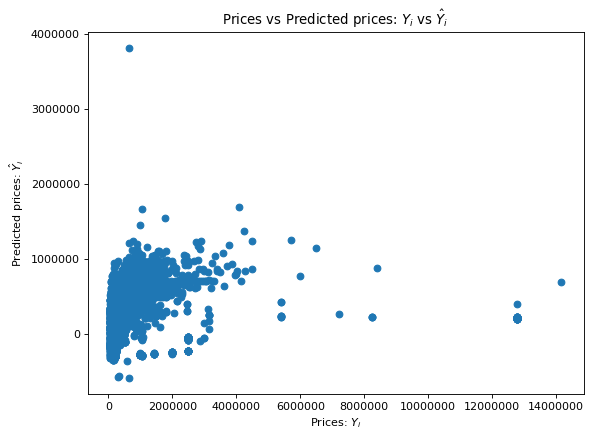

In [435]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ticklabel_format(style = 'plain')

plt.scatter(y_col_test, y_col_lin_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

# Use Logistic Regression (dataset is to complex for my computer to compute this)

## train the model

In [387]:
# print("Start training")
# logreg_row = LogisticRegression(n_jobs = -1, solver = "sag", max_iter=100000)
# logreg_row.fit(x_row_no_cat_train, y_row_train)
# print("Training finished")

In [388]:
# print("Start training")
# logreg_col = LogisticRegression(n_jobs = -1, solver = "sag", max_iter=100000, normalize = True)
# logreg_col.fit(x_col_train, y_col_train)
# print("Training finished")

## predict the test data

In [389]:
# y_row_log_pred = logreg_row.predict(x_row_no_cat_test)

In [390]:
# y_col_log_pred = logreg_col.predict(x_col_no_cat_test)

## analyze results

In [391]:
# row_log_score = logreg_row.score(x_row_no_cat_test, y_row_test)
# print("R2 score for the row dataset: " + str(row_log_score))

In [392]:
# plt.scatter(y_row_test, y_row_log_pred)
# plt.xlabel("Prices: $Y_i$")
# plt.ylabel("Predicted prices: $\hat{Y}_i$")
# plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
# plt.show()

In [393]:
# col_log_score = logreg_col.score(x_col_no_cat_test, y_col_test)
# print("R2 score for the column dataset: " + str(col_log_score))

In [394]:
# plt.scatter(y_col_test, y_col_lin_pred)
# plt.xlabel("Prices: $Y_i$")
# plt.ylabel("Predicted prices: $\hat{Y}_i$")
# plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
# plt.show()

# KNN

In [395]:
# # train the model
# print("Start training")
# knn_row = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)
# knn_row.fit(x_row_one_hot_train, y_row_train)
# print("Finished training")

# # predict the test data
# y_row_knn_pred = knn_row.predict(x_row_one_hot_test)

# # output
# print(classification_report(y_row_test, y_row_knn_pred))

In [396]:
# # train the model
# print("Start training")
# knn_col = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)
# knn_col.fit(x_col_one_hot_train, y_col_train)
# print("Finished training")

# # predict the test data
# y_col_knn_pred = knn_col.predict(x_col_one_hot_test)

# # output
# print(classification_report(y_col_test, y_col_knn_pred))

# Random Forest

In [397]:
# param_dist = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [1, 20]}

# print("Start training")
# RFR = RandomForestRegressor(n_jobs = -1)
# RFR_cv = RandomizedSearchCV(RFR, param_dist)
# RFR_cv.fit(x_row_one_hot_train, y_row_train)
# print("Finished training")
# evaluate(RFR_cv.best_estimator_, x_row_one_hot_test, y_row_test)

In [398]:
# y_row_rf_predict = RFR.predict(x_row_one_hot_test)

In [399]:
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.ticklabel_format(style = 'plain')

# plt.scatter(y_row_test, y_row_rf_predict)
# plt.xlabel("Prices: $Y_i$")
# plt.ylabel("Predicted prices: $\hat{Y}_i$")
# plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
# plt.show()

# NN

In [429]:
model = Sequential()
model.add(Dense(800, activation="tanh", kernel_initializer='normal', input_shape=(469,)))
model.add(Dropout(0.45))
model.add(Dense(1200, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.4))
model.add(Dense(200, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
model.add(Dropout(0.35))
model.add(Dense(100, activation="relu", kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(
    loss='mean_squared_error',
    optimizer='nadam',
    metrics=["mae"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 800)               376000    
_________________________________________________________________
dropout_71 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 1200)              961200    
_________________________________________________________________
dropout_72 (Dropout)         (None, 1200)              0         
_________________________________________________________________
dense_104 (Dense)            (None, 200)               240200    
_________________________________________________________________
dropout_73 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 100)               20100     
__________

In [430]:
history = model.fit(x_row_one_hot_norm_train, 
          y_row_train,
          batch_size = 64,
          shuffle = True,
          epochs = 40,
          validation_data = (x_row_one_hot_norm_test, y_row_test))

Train on 34280 samples, validate on 14691 samples
Epoch 1/40
34280/34280 [==============================] - 45s 1ms/step - loss: 200362744531.1328 - mean_absolute_error: 246446.7472 - val_loss: 75210924952.6311 - val_mean_absolute_error: 191975.9369
Epoch 2/40
34280/34280 [==============================] - 41s 1ms/step - loss: 125299686976.6422 - mean_absolute_error: 200120.8033 - val_loss: 87299170999.9102 - val_mean_absolute_error: 218879.7599
Epoch 3/40
34280/34280 [==============================] - 40s 1ms/step - loss: 113330758390.9788 - mean_absolute_error: 194530.3687 - val_loss: 87713685123.1453 - val_mean_absolute_error: 216499.5375
Epoch 4/40
34280/34280 [==============================] - 40s 1ms/step - loss: 109659842540.4042 - mean_absolute_error: 193115.2154 - val_loss: 88807197215.2616 - val_mean_absolute_error: 224608.1020
Epoch 5/40
34280/34280 [==============================] - 41s 1ms/step - loss: 104421730898.0873 - mean_absolute_error: 189763.0822 - val_loss: 981211

In [431]:
train_score = model.evaluate(x_row_one_hot_norm_train, y_row_train, verbose=0)
valid_score = model.evaluate(x_row_one_hot_norm_test, y_row_test, verbose=0)

y_pred = model.predict(x_row_one_hot_norm_test)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  137380.9975 , Train Loss:  48568231999.3
Val MAE:  290989.1631 , Val Loss:  133380835021.0


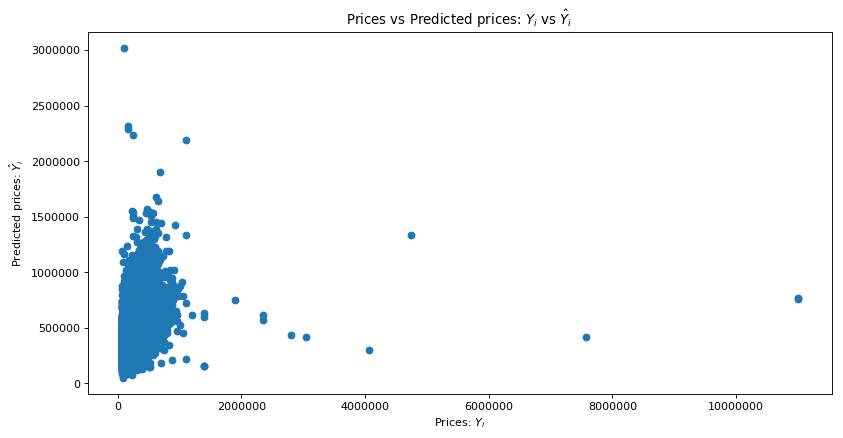

In [432]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ticklabel_format(style = 'plain')

plt.scatter(y_row_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

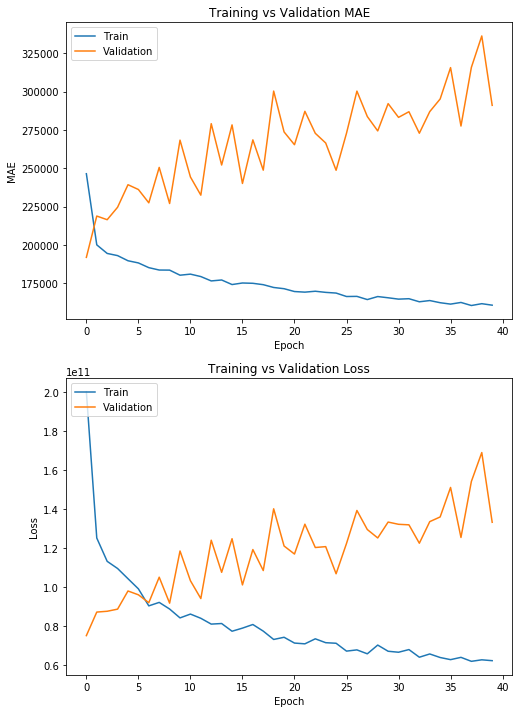

In [433]:

def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

plot_hist(history.history, xsize=8, ysize=12)